<h1 align="center">МЧС: прогнозирование степени пожароопасности</h1>

![](https://habrastorage.org/webt/hw/ov/mm/hwovmmzc0n6y59iamjoa11zvce0.jpeg)

---

> **ЗАДАЧА:** разработать алгоритм, выдающий бинарную (0 или 1) вероятность пожара на 1, 2, 3, 4, 5, 6, 7 и 8 дней вперёд для заданной ячейки на определённую дату.  Решение должно быть реализовано в виде программы, которая принимает на вход CSV таблицу с точками (координаты `latitude`, `longitude` и дата получения точки `dt`). На выход необходимо формировать таблицу где для каждой точки будут указаны 8 чисел (0 или 1) означающие наличие пожара через 1, 2, 3, 4, 5, 6, 7 и 8 дней соответственно.


---

<h1 align="center">Оглавление</h1>

- [1. Загрузка данных](#part1) <br>
    - [1.1 Климатические данные](#part1.1) <br>
    - [1.2 Таргеты](#part1.2) <br>
    - [1.3 OpenStreetMap](#part1.3) <br>
- [2. Генерация признаков](#part2) <br>
    - [2.1 Pooling features](#part2.1) <br>
    - [2.2 Categorical признаки даты](#part2.2) <br>
    - [2.3 Гео признаки](#part2.3) <br>
- [3. Обучение моделей](#part3) <br>
- [4. sample_submission.zip](#part4) <br>
- [5. Метрика соревнования](#part5) <br>

---

<h1 align="center">0. Импорт необходимых библиотек</h1>

> **NOTE**: Для некоторых библиотек потребуется установка дополнительных зависимостей. Более детальную информацию вы сможете найти в нашем **Dockerfile**

In [1]:
import os
import pickle
import cfgrib
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from catboost import Pool, CatBoostClassifier
from OSMPythonTools.nominatim import Nominatim
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass

import helpers, preprocessing, features_generation
from solution import FEATURES

import warnings
warnings.simplefilter("ignore")
plt.rcParams["figure.figsize"] = (16,8)

---

<a id='part1'></a>
<h1 align="center">1. Загрузка данных</h1>

<a id='part1.1'></a>
<h2 align="center">1.1 Климатические данные</h2>

### Пример работы с файлом `.grib`

In [2]:
ds = cfgrib.open_datasets('input/ERA5_data/temp_2018.grib')

In [3]:
len(ds)

3

Файл представляет из себя несколько объектов формата `xarray.Dataset`, например, файл `temp_2018.grib` состоит из 3 объектов. Объекты содержат значения признаков для трех измерений **(latitude: 406, longitude: 1501, time: 365)**:
- Первый объект содержит следующий набор признаков:
    - stl1: Soil temperature level 1
- Второй объект содержит:
    - t2m: 2 metre temperature
    - d2m: 2 metre dewpoint temperature
- Третий объект содержит:
    - skt: Skin temperature

> **NOTE**: Данные признаки являются измерениями на определенную дату, в определенной широте и долготе, частота признаков 0.1 градус

In [4]:
ds[0].indexes['time'].min(), ds[0].indexes['time'].max()

(Timestamp('2018-01-01 14:00:00'), Timestamp('2018-12-31 14:00:00'))

In [5]:
# ds[2]

### Визуализация объекта `xarray.Dataset`

Очень хорошо видны очертания России 🇷🇺

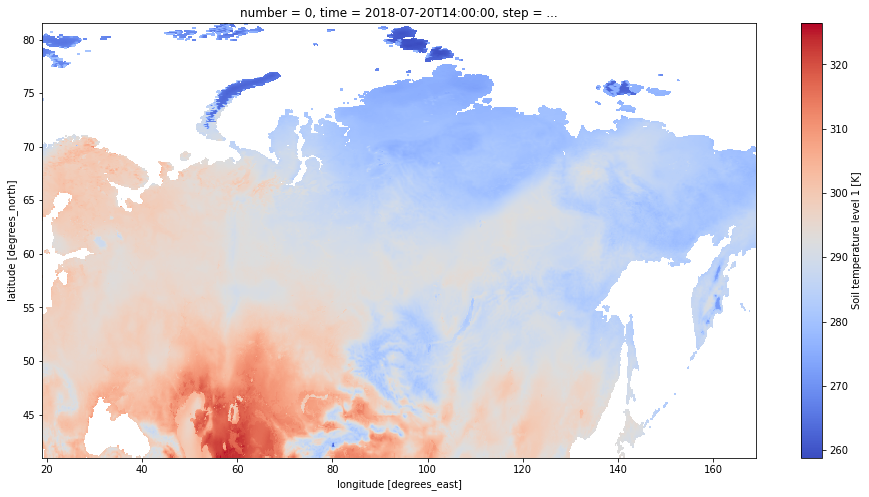

In [6]:
ds[0].stl1[200].plot(cmap=plt.cm.coolwarm);

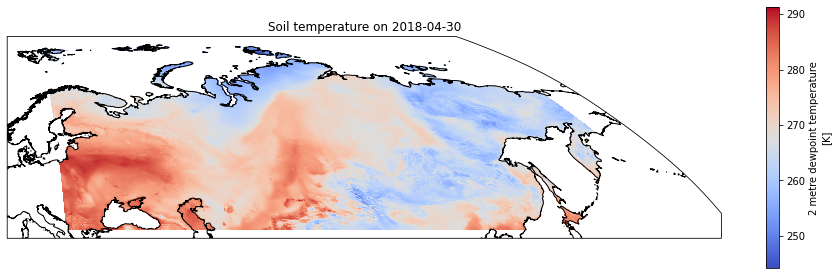

In [7]:
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution='10m')
plot = ds[1].d2m[119].plot(cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink':0.6})
plt.title('Soil temperature on 2018-04-30');

### Парсим куб из `xarray.Dataset` из файла `temp_2018.grib`

Для дальнейшей работы с климатическими признаками, можно парсить объекты `xarray.Dataset`, например, функциями `parse_dims` и `parse_cube`

> **NOTE**: 
> - Результат работы функции `parse_cube`: `словарь` ключ - название признака, значение - **3-мерный numpy массив** (день, ширина, долгота)
> - Результат работы функции `parse_dims`: **1-мерные массивы** с информацией о значениях осей 3-мерного массива.

In [8]:
times, latitudes, longitudes = preprocessing.parse_dims(ds)

Наблюдаем, что широта отсортирована по убыванию, что не естественно для матричного представления, учтем это

In [9]:
latitudes

Float64Index([              81.5,               81.4,  81.30000000000001,
               81.20000000000002,  81.10000000000002,  81.00000000000003,
               80.90000000000003,  80.80000000000004,  80.70000000000005,
               80.60000000000005,
              ...
               41.90000000000068,  41.80000000000068,  41.70000000000068,
              41.600000000000676, 41.500000000000675, 41.400000000000674,
               41.30000000000067,  41.20000000000067,  41.10000000000067,
               41.00000000000067],
             dtype='float64', name='latitude', length=406)

In [10]:
longitudes

Float64Index([              19.0,               19.1, 19.200000000000003,
              19.300000000000004, 19.400000000000006, 19.500000000000007,
               19.60000000000001,  19.70000000000001,  19.80000000000001,
              19.900000000000013,
              ...
              168.09999999999474, 168.19999999999473, 168.29999999999472,
              168.39999999999472,  168.4999999999947,  168.5999999999947,
               168.6999999999947,  168.7999999999947,  168.8999999999947,
              168.99999999999469],
             dtype='float64', name='longitude', length=1501)

<a id='part1.2'></a>
<h2 align="center">1.2 Таргеты</h2>

### Загружаем таргеты

####  `train.csv`
Датасет для обучения моделей.
- **dt** - Текущая дата наблюдения;
- **lon_min** - Нижняя граница ячейки наблюдения по `долготе`;
- **lat_min** - Нижняя граница ячейки наблюдения по `широте`;
- **lon_max** - Верхняя граница ячейки наблюдения по `долготе`;
- **lat_max** - Верхняя граница ячейки наблюдения по `широте`;
- **lon** - Координата конкретной точки пожара - `долготы` **(при наличии)**;
- **lat** - Координата конкретной точки пожара - `широты` **(при наличии)**;
- **type_id** - Код типа пожара **(при наличии)**;
- **type_name** - Наименование типа пожара **(при наличии)**;
--------------
- **infire_after_1_day** - `Целевая переменная` вероятность пожара на следующий день;
- **infire_after_2_day** - `Целевая переменная` вероятность пожара через 2 дня;
- **infire_after_3_day** - `Целевая переменная` вероятность пожара через 3 дня;
- **infire_after_4_day** - `Целевая переменная` вероятность пожара через 4 дня;
- **infire_after_5_day** - `Целевая переменная` вероятность пожара через 5 дней;
- **infire_after_6_day** - `Целевая переменная` вероятность пожара через 6 дней;
- **infire_after_7_day** - `Целевая переменная` вероятность пожара через 7 дней;
- **infire_after_8_day** - `Целевая переменная` вероятность пожара через 8 дней;

> **NOTE**: Размер ячейки 0.2 x 0.2 широты - долготы

In [11]:
train = pd.read_csv('input/train.csv', parse_dates=['dt'])
print(train.shape)
train.head()

(1761804, 17)


,dt,lon_min,lat_min,lon_max,lat_max,lon,lat,type_id,type_name,infire_after_1_day,infire_after_2_day,infire_after_3_day,infire_after_4_day,infire_after_5_day,infire_after_6_day,infire_after_7_day,infire_after_8_day
0,2018-03-24,20.0,41.2,20.2,41.4,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
1,2018-04-08,20.0,41.2,20.2,41.4,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
2,2018-04-30,20.0,41.2,20.2,41.4,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
3,2018-06-16,20.0,41.2,20.2,41.4,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
4,2018-06-27,20.0,41.2,20.2,41.4,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0


In [12]:
train.dt.min(), train.dt.max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2021-03-31 00:00:00'))

####  `test.csv`

Поля повторяют поля `train.csv`, за исключением целевых переменных. По вашим предсказаниям пожаров для данных наблюдений будет создан публичный лидерборд

In [13]:
test = pd.read_csv('input/test.csv', parse_dates=['dt'])
print(test.shape)
test.head()

(95923, 9)


,dt,lon_min,lat_min,lon_max,lat_max,lon,lat,type_id,type_name
0,2021-04-03,20.6,41.2,20.8,41.4,NaN,NaN,NaN,NaN
1,2021-04-04,20.6,41.2,20.8,41.4,NaN,NaN,NaN,NaN
2,2021-04-16,20.6,41.2,20.8,41.4,NaN,NaN,NaN,NaN
3,2021-04-01,21.4,41.2,21.6,41.4,NaN,NaN,NaN,NaN
4,2021-04-27,21.4,41.2,21.6,41.4,NaN,NaN,NaN,NaN


In [14]:
test.dt.min(), test.dt.max()

(Timestamp('2021-04-01 00:00:00'), Timestamp('2021-04-30 00:00:00'))

### Разделим выборку `train` на `train/val` датасеты

> **NOTE**: В рамках этого бейзлайна, выбираем данные для обучения **только** с 2020 года

In [15]:
val = train[train.dt >= "2021-01-01"].reset_index(drop=True)
train = train[(train.dt >= "2020-01-01") & (train.dt < "2021-01-01")].reset_index(drop=True)

In [16]:
train.shape, val.shape, test.shape

((605734, 17), (112908, 17), (95923, 9))

### Посмотрим на распределение таргетов:

In [17]:
train[['infire_after_1_day', 'infire_after_2_day', 'infire_after_3_day', 'infire_after_4_day', 'infire_after_5_day']].apply(pd.Series.value_counts)

,infire_after_1_day,infire_after_2_day,infire_after_3_day,infire_after_4_day,infire_after_5_day
0,553748,553738,553729,553712,553690
1,51986,51996,52005,52022,52044


In [18]:
val[['infire_after_1_day', 'infire_after_2_day', 'infire_after_3_day', 'infire_after_4_day', 'infire_after_5_day']].apply(pd.Series.value_counts)

,infire_after_1_day,infire_after_2_day,infire_after_3_day,infire_after_4_day,infire_after_5_day
0,108789,108705,108564,108397,108245
1,4119,4203,4344,4511,4663


### Добавляем `grid_index` для таргетов

Для удобства добавления признаков к нашим наблюдениям можно использовать `grid_index`, который заменит границы ячейки одним числом, которое вычисляется по простой формуле:

$$\mathcal grid\_index = row_i * col_n + col_i,$$  
в нашем случае всего столбцов (`col_n`) - **750**, всего строк - **203**.

> **NOTE**: В качестве начальных значений для индексации будем использовать **минимальные** значения ширины и долготы в файлах `.grib`, по той причине - потому что они меньше, чем минимальные значения в таргетах

![](https://habrastorage.org/webt/ji/cf/js/jicfjs3yfotvsvwxsp85eqifxtq.jpeg)

In [19]:
lat_min = round(latitudes.min(), 1)
lat_max = round(latitudes.max(), 1)

lon_min = round(longitudes.min(), 1)
lon_max = round(longitudes.max(), 1)

lat_min, lat_max, lon_min, lon_max

(41.0, 81.5, 19.0, 169.0)

In [20]:
step = 0.2
array_of_lats = np.arange(lat_min, lat_max, step).round(1)
array_of_lons = np.arange(lon_min, lon_max, step).round(1)
print(len(array_of_lats), len(array_of_lons))

203 750


In [21]:
%%time
train = helpers.get_grid_index(train, array_of_lons, array_of_lats)
val = helpers.get_grid_index(val, array_of_lons, array_of_lats)

CPU times: user 2min 10s, sys: 13.7 s, total: 2min 23s
Wall time: 1min 42s


<a id='part1.3'></a>
<h2 align="center">1.3 OpenStreetMap</h2>

### Скачиваем информацию используя `OSMPythonTools` по ключу [Key:place](https://wiki.openstreetmap.org/wiki/Key:place)

- Обратите внимание на [Key:natural](https://wiki.openstreetmap.org/wiki/Key:place)
- если загрузка слишком долгая, можно воспользоваться веб-сервисом `https://overpass-turbo.eu/#`, выполнить запрос, экспортировать в файл, например `.geojson`. (При обращении к api есть квота по ip)

Пример запроса к веб-сервису, который идентичен коду ниже:

```
[out:json][timeout:1000];
area(3600060189)->.searchArea;
(
  node["place"~"city|town|village"](area.searchArea);
  way["place"~"city|town|village"](area.searchArea);
  relation["place"~"city|town|village"](area.searchArea);
);
out body;
>;

```  

>**NOTE**: файл **city_town_village.geojson** получен именно таким образом

In [22]:
# nominatim = Nominatim()
# areaId = nominatim.query('Россия').areaId()
# areaId

In [23]:
# overpass = Overpass()
# query = overpassQueryBuilder(area=areaId, elementType=['node', 'way', 'relation'], selector='"place"~"city|town|village"')
# result = overpass.query(query, timeout=1000)
# res_json = result.toJSON()

### Загружаем `.geojson` в `geopandas`

Итак, мы получили файл `*.geojson` одним из двух способов, далее будем работать с ним с помощью библиотеки `geopandas`.
> **NOTE**: Для примера, выбраны не все потенциально полезные столбцы;  
Также можно учесть, что значение признака `population` было зафиксировано на определенную дату. В данном бейзлайне пренебрегаем возможным `data leakage` и не актуальным значением.

In [24]:
cities_df = gpd.read_file('input/city_town_village.geojson')
cities_df = cities_df[['admin_level', 'name', 'population', 'population:date', 'place', 'geometry']]
cities_df = cities_df[cities_df.place != 'city_block'].reset_index(drop=True)
cities_df['lon'] = cities_df['geometry'].x
cities_df['lat'] = cities_df['geometry'].y

cities_df.loc[cities_df.lon < 0, 'lon'] += 360
cities_df.loc[cities_df.population.notna(), 'population'] = cities_df[cities_df.population.notna()]\
                            .population.apply(helpers.split_string).str.replace(" ", "").astype(int)
cities_df.head()

,admin_level,name,population,population:date,place,geometry,lon,lat
0,3,Новосибирск,1625600,2020-01-01,city,POINT (82.92345 55.02822),82.923451,55.028217
1,None,Невель,16272,None,town,POINT (29.91713 56.01762),29.917128,56.017616
2,None,Кандалакша,30575,2019-01-01,town,POINT (32.41306 67.15144),32.413055,67.151442
3,6,Апатиты,55713,2018-01-01,town,POINT (33.40439 67.56863),33.404392,67.568626
4,None,Калевала,3855,2019-01-01,town,POINT (31.18017 65.20010),31.180172,65.200096


### Переводим значения city_lon и city_lat к нашей сетке

Координаты центра каждого поселения переводим в рамки наших границ ячеек, как в таргетах

In [25]:
cities_df = helpers.add_edges_polygon(cities_df)
lat_min, lat_max, lon_min, lon_max = (41.0, 81.5, 19.0, 169.0)
cities_df = cities_df[(cities_df.lon_max <= lon_max) &\
                      (cities_df.lon_min >= lon_min) &\
                      (cities_df.lat_min >= lat_min) &\
                      (cities_df.lat_max <= lat_max)].reset_index(drop=True)

### Добавляем `grid_index` для городов

После того как мы добавили границы для ячейки размера 0.2 x 0.2 широты - долготы, можем добавить `grid_index`

In [26]:
cities_df = helpers.get_grid_index(cities_df, array_of_lons, array_of_lats)

### Переименовываем для удобства

In [27]:
cities_df.rename(columns={'lon': 'city_lon',
                          'lat': 'city_lat'}, inplace=True)
cities_df.head()

,admin_level,name,population,population:date,place,geometry,city_lon,city_lat,lon_min,lon_max,lat_min,lat_max,grid_index
0,3,Новосибирск,1625600,2020-01-01,city,POINT (82.92345 55.02822),82.923451,55.028217,82.8,83.0,55.0,55.2,52819
1,None,Невель,16272,None,town,POINT (29.91713 56.01762),29.917128,56.017616,29.8,30.0,56.0,56.2,56304
2,None,Кандалакша,30575,2019-01-01,town,POINT (32.41306 67.15144),32.413055,67.151442,32.4,32.6,67.0,67.2,97567
3,6,Апатиты,55713,2018-01-01,town,POINT (33.40439 67.56863),33.404392,67.568626,33.4,33.6,67.4,67.6,99072
4,None,Калевала,3855,2019-01-01,town,POINT (31.18017 65.20010),31.180172,65.200096,31.0,31.2,65.2,65.4,90810


---

<a id='part2'></a>
<h1 align="center">2. Генерация признаков</h1>

<a id='part2.1'></a>
<h2 align="center">2.1 Pooling features</h2>

![](https://habrastorage.org/webt/dy/w1/_k/dyw1_kokc_kch6f-d37esfptjbw.jpeg)

Так как в нашем датасете у таргетов размер ячеек 0.2 x 0.2, а у климатических признаков частота измерений 0.1, мы можем использовать либо всю матрицу 0.2 х 0.2 целиком, либо использовать `pooling` c `kernel_size` = 3 и `stride` = 2

### Считаем `pooling features`
И сразу переводим в так называемый `grid_index`, по которому в дальнейшем будем матчить с таргетами и сохраняем полученные тензоры в `additional_data/`

> **NOTE**: 
> - Так как для обучения мы взяли данные **только** с 2020 года, соответственно считаем `poolling features` также только для данных с 2020 года;  
> - Из доступных климатических признаков для бейзлайна выбираем `temp` и `wind`.

In [28]:
%%time

PATH_TO_ADD_DATA = 'additional_data/'

grib_list = [el.split('.')[0] for el in os.listdir("input/ERA5_data")\
             if el.startswith(("temp", "wind")) and el.endswith(('2020.grib', '2021.grib'))]

for file_name in grib_list:
    preprocessing.make_pool_features("input/ERA5_data",
                                     file_name, PATH_TO_ADD_DATA)

CPU times: user 1min 18s, sys: 21.8 s, total: 1min 39s
Wall time: 1min 17s


### Добавляем признаки из подготовленного тензорного представления

In [29]:
%%time
PATH_TO_ADD_DATA = 'additional_data/'
train = features_generation.add_pooling_features(train, PATH_TO_ADD_DATA, count_lag=3)
val = features_generation.add_pooling_features(val, PATH_TO_ADD_DATA, count_lag=3)

CPU times: user 1min 53s, sys: 6.27 s, total: 2min
Wall time: 1min 49s


<a id='part2.2'></a>
<h2 align="center">2.2 Categorical признаки даты</h2>

Добавляем в качестве категориальных признаков - месяц, день месяца, неделя с начала года, день недели.

In [30]:
train = features_generation.add_cat_date_features(train)
val = features_generation.add_cat_date_features(val)

<a id='part2.3'></a>
<h2 align="center">2.3 Гео признаки</h2>

****Добавляем признаки полученные из `OpenStreetMap`****:
- **distance_to_nearest_city** - расстояние до ближайшего населенного пункта;
- **place** - тип населенного пункта;
- **population** - численность населения

In [31]:
%%time
train = features_generation.add_geo_features(train, cities_df)
val = features_generation.add_geo_features(val, cities_df)

CPU times: user 17.3 s, sys: 0 ns, total: 17.3 s
Wall time: 17.3 s


---

<a id='part3'></a>
<h1 align="center">3. Обучение моделей</h1>

Итак, наш датасет готов, можем приступать к обучению.  
В качестве бейзлайна выбрана модель `CatBoostClassifier`.
> **NOTE**: для каждого из таргетов будем обучать классификатор отдельно

In [32]:
cat_features = ['month', 'day', 'weekofyear', 'dayofweek', 'place']
cat_features = train[FEATURES].columns.intersection(cat_features)
cat_features = [train[FEATURES].columns.get_loc(feat) for feat in cat_features]
cat_features

[65, 67, 68, 69, 70]

In [33]:
models = []
for i in range(8):
    train_dataset = Pool(data=train[FEATURES],
                        label=train.iloc[:,9+i],
                        cat_features=cat_features)

    eval_dataset = Pool(data=val[FEATURES],
                        label=val.iloc[:,9+i],
                        cat_features=cat_features)
    model = CatBoostClassifier(iterations=100, random_seed=i+1, eval_metric='F1', auto_class_weights="Balanced")
    model.fit(train_dataset,
              eval_set=eval_dataset,
              verbose=False)
    models.append(model)

### Сохраняем модели в `models/`

In [34]:
if not os.path.exists("models/"):
    os.mkdir("models/")
for idx, model in enumerate(models):
    path_to_model = f"models/model_{idx+1}_day.pkl"

    with open(path_to_model, 'wb') as f:  
        pickle.dump(model, f)

---

<a id='part4'></a>
<h1 align="center">4. sample_submission.zip</h1>

В качестве решения от участников требуется архив `*.zip`:

```
.
├── features_generation.py
├── helpers.py
├── metadata.json
├── models
│   ├── model_1_day.pkl
│   ├── model_2_day.pkl
│   ├── model_3_day.pkl
│   ├── model_4_day.pkl
│   ├── model_5_day.pkl
│   ├── model_6_day.pkl
│   ├── model_7_day.pkl
│   └── model_8_day.pkl
├── preprocessing.py
└── solution.py

```

- В директории `models/` обязательно должны быть файлы с моделями.
- В директории `additional_data/` могут быть дополнительные данные для обучения модели; Директории может не быть.
- Помимо обязательного модуля `solution.py` могут быть вспомогательные модули.
- Файл `metadata.json` содержит название `docker image` и команду для расчета `*.csv` таблицы, порядок строки у которой - строка из датасета `test.csv`:
```
infire_after_1_day,infire_after_2_day,infire_after_3_day,infire_after_4_day,infire_after_5_day,infire_after_6_day,infire_after_7_day,infire_after_8_day
0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0
```

In [35]:
!zip -r sample_submission.zip *.py models/ metadata.json >/dev/null

---

<a id='part5'></a>
<h1 align="center">5. Метрика соревнования</h1>

> **NOTE**: 
> - Код метрики представлен в `helpers.competition_metric`
> - Лучшая метрика → 0, худшая → 1

#### В качестве примера расчета метрики, рассмотрим 2 датасета

In [36]:
pred = pd.DataFrame({'infire_after_1_day': [1, 0, 1, 0, 0],
                     'infire_after_2_day': [1, 0, 1, 0, 0],
                     'infire_after_3_day': [1, 0, 1, 0, 0],
                     'infire_after_4_day': [1, 0, 0, 0, 0],
                     'infire_after_5_day': [1, 1, 0, 0, 1],
                     'infire_after_6_day': [1, 0, 1, 0, 1],
                     'infire_after_7_day': [1, 0, 1, 0, 0],
                     'infire_after_8_day': [1, 0, 1, 0, 1],
                    })

pred

,infire_after_1_day,infire_after_2_day,infire_after_3_day,infire_after_4_day,infire_after_5_day,infire_after_6_day,infire_after_7_day,infire_after_8_day
0,1,1,1,1,1,1,1,1
1,0,0,0,0,1,0,0,0
2,1,1,1,0,0,1,1,1
3,0,0,0,0,0,0,0,0
4,0,0,0,0,1,1,0,1


In [37]:
gt = pd.DataFrame({'infire_after_1_day': [0, 0, 0, 0, 0],
                   'infire_after_2_day': [0, 0, 0, 0, 0],
                   'infire_after_3_day': [1, 0, 0, 0, 1],
                   'infire_after_4_day': [0, 1, 0, 0, 1],
                   'infire_after_5_day': [0, 0, 0, 0, 1],
                   'infire_after_6_day': [0, 0, 0, 0, 0],
                   'infire_after_7_day': [1, 0, 0, 0, 0],
                   'infire_after_8_day': [0, 0, 0, 0, 0],
                  })

gt

,infire_after_1_day,infire_after_2_day,infire_after_3_day,infire_after_4_day,infire_after_5_day,infire_after_6_day,infire_after_7_day,infire_after_8_day
0,0,0,1,0,0,0,1,0
1,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0
4,0,0,1,1,1,0,0,0


In [38]:
helpers.competition_metric(gt, pred)

0.057845999999999995